In [1]:
modelType = "my-model-rnn" # "model-RNN"

In [ ]:
!wget -q https://raw.githubusercontent.com/DeNatur/RNNSpeechCommands/main/GoogleCommandsRepository.py
!wget -q https://raw.githubusercontent.com/DeNatur/RNNSpeechCommands/main/RNNModels.py
!wget -q https://raw.githubusercontent.com/DeNatur/RNNSpeechCommands/main/SequenceGenerator.py
!wget -q https://raw.githubusercontent.com/DeNatur/RNNSpeechCommands/main/audioUtils.py
!wget -q https://raw.githubusercontent.com/DeNatur/RNNSpeechCommands/main/requirements.txt
!pip install -r requirements.txt

In [2]:
import tensorflow as tf
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 6137036330850633076
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 9924153793718095824
physical_device_desc: "device: XLA_CPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 5060693856
locality {
  bus_id: 1
  links {
  }
}
incarnation: 7858340565993830524
physical_device_desc: "device: 0, name: NVIDIA GeForce GTX 1060 6GB, pci bus id: 0000:01:00.0, compute capability: 6.1"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 6510351731995061915
physical_device_desc: "device: XLA_GPU device"
]


In [3]:
import librosa
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline  

import GoogleCommandsRepository
import SequenceGenerator
# import RNNModels
from RNNModels import RNNSpeechModel, AttRNNSpeechModel, my_RNNSpeechModel

In [4]:
# Download and prepare all data
gscInfo, nCategs = GoogleCommandsRepository.PrepareGoogleSpeechCmd(task='35word')

Done preparing Google Speech commands dataset


In [ ]:
sr = 16000 #we know this one for google audios
iLen = 16000
trainGen = SequenceGenerator.SequenceGenerator(gscInfo['train']['files'], gscInfo['train']['labels'], shuffle=True)
# handle the fact that number of samples in validation may not be multiple of batch_size with shuffle=True
valGen   = SequenceGenerator.SequenceGenerator(gscInfo['val']['files'], gscInfo['val']['labels'], shuffle=True)

# use batch_size = total number of files to read all test files at once
testGen  = SequenceGenerator.SequenceGenerator(gscInfo['test']['files'], gscInfo['test']['labels'], shuffle=False, batch_size=len(gscInfo['test']['files']))
testRGen = SequenceGenerator.SequenceGenerator(gscInfo['testREAL']['files'], gscInfo['testREAL']['labels'], shuffle=False, batch_size=len(gscInfo['testREAL']['files']))
valGen.__len__()

In [6]:
audios, classes = valGen.__getitem__(5)
classes

array([18, 29, 13, 17,  1, 10, 21, 16,  7, 10,  4, 19, 16, 33,  9, 18, 11,
       11, 11,  4, 20, 16, 15,  2, 27, 32, 17, 10,  5,  6, 31,  6])

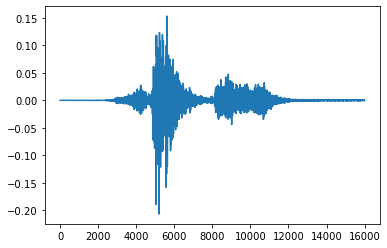

In [9]:
plt.plot(audios[4])

In [7]:
from tensorflow.keras.models import Model, load_model

from kapre.time_frequency import Melspectrogram, Spectrogram

In [11]:
#self-attention LSTM
#nCategs=36
#sr=16000
#iLen=16000
#from keras import layers as L

# ### Model z atencja
# if modelType != "model-attRNN":
#     model = AttRNNSpeechModel(nCategs, samplingrate = sr, inputLength = None)#, rnn_func=L.LSTM)
# else:
# ### Model bez atencji
#     model = RNNSpeechModel(nCategs, samplingrate = sr, inputLength = None)#, rnn_func=L.LSTM)

### My Model
model = my_RNNSpeechModel(nCategs, samplingrate = sr, inputLength = None)#, rnn_func=L.LSTM)

model.compile(optimizer='adam', loss=['sparse_categorical_crossentropy'], metrics=['sparse_categorical_accuracy'])
# model.summary()

In [11]:
#self-attention LSTM
#nCategs=36
#sr=16000
#iLen=16000
#from keras import layers as L

### Model z atencja
if modelType != "model-attRNN":
    model = AttRNNSpeechModel(nCategs, samplingrate = sr, inputLength = None)#, rnn_func=L.LSTM)
else:
### Model bez atencji
    model = RNNSpeechModel(nCategs, samplingrate = sr, inputLength = None)#, rnn_func=L.LSTM)

model.compile(optimizer='adam', loss=['sparse_categorical_crossentropy'], metrics=['sparse_categorical_accuracy'])
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, None)]       0                                            
__________________________________________________________________________________________________
reshape_3 (Reshape)             (None, 1, None)      0           input[0][0]                      
__________________________________________________________________________________________________
mel_stft (Melspectrogram)       (None, 80, None, 1)  1091664     reshape_3[0][0]                  
__________________________________________________________________________________________________
mel_stft_norm (Normalization2D) (None, 80, None, 1)  0           mel_stft[0][0]                   
_______________________________________________________________________________________

In [12]:
import math
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler
def step_decay(epoch):
    initial_lrate = 0.001
    drop = 0.4
    epochs_drop = 15.0
    lrate = initial_lrate * math.pow(drop,  
            math.floor((1+epoch)/epochs_drop))
    
    if (lrate < 4e-5):
        lrate = 4e-5
      
    print('Changing learning rate to {}'.format(lrate))
    return lrate
lrate = LearningRateScheduler(step_decay)

In [13]:
earlystopper = EarlyStopping(monitor='val_sparse_categorical_accuracy', patience=10,
                             verbose=1, restore_best_weights=True)
checkpointer = ModelCheckpoint(modelType + ".h5", monitor='val_sparse_categorical_accuracy', verbose=1, save_best_only=True)

results = model.fit(trainGen, validation_data=valGen, epochs=60, use_multiprocessing=False, workers=4, verbose=2,
                    callbacks=[earlystopper, checkpointer, lrate])

model.save(modelType + ".h5")

Changing learning rate to 0.001
Epoch 1/60

Epoch 00001: val_sparse_categorical_accuracy improved from -inf to 0.54070, saving model to my-model-rnn.h5
2651/2651 - 323s - loss: 2.4702 - sparse_categorical_accuracy: 0.2932 - val_loss: 1.5403 - val_sparse_categorical_accuracy: 0.5407
Changing learning rate to 0.001
Epoch 2/60

Epoch 00002: val_sparse_categorical_accuracy improved from 0.54070 to 0.68539, saving model to my-model-rnn.h5
2651/2651 - 317s - loss: 1.2694 - sparse_categorical_accuracy: 0.6220 - val_loss: 1.0521 - val_sparse_categorical_accuracy: 0.6854
Changing learning rate to 0.001
Epoch 3/60

Epoch 00003: val_sparse_categorical_accuracy improved from 0.68539 to 0.76698, saving model to my-model-rnn.h5
2651/2651 - 311s - loss: 0.9018 - sparse_categorical_accuracy: 0.7301 - val_loss: 0.7616 - val_sparse_categorical_accuracy: 0.7670
Changing learning rate to 0.001
Epoch 4/60

Epoch 00004: val_sparse_categorical_accuracy improved from 0.76698 to 0.78648, saving model to my-mod

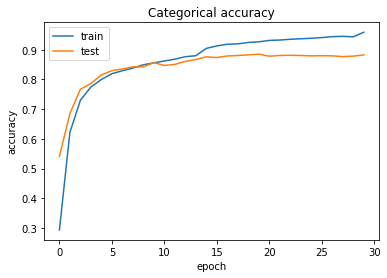

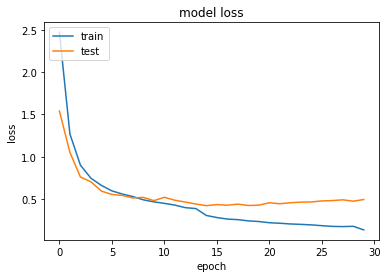

In [14]:
# summarize history for categorical accuracy
plt.plot(results.history['sparse_categorical_accuracy'])
plt.plot(results.history['val_sparse_categorical_accuracy'])
plt.title('Categorical accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(results.history['loss'])
plt.plot(results.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
# load best model according to cross-validation - model-attRNN
# model = load_model(modelType + ".h5", custom_objects={'Melspectrogram': Melspectrogram, 'Normalization2D': Normalization2D })
model.load_weights(modelType + ".h5")

In [ ]:
#read all test data
x_test, y_test = testGen.__getitem__(0)

In [ ]:
valEval = model.evaluate(valGen, use_multiprocessing=False, workers=4,verbose=0)
trainEval = model.evaluate(trainGen, use_multiprocessing=False, workers=4,verbose=0)
testEval = model.evaluate(x_test, y_test, verbose=0)
print('Evaluation scores: \nMetrics: {} \nTrain: {} \nValidation: {} \nTest: {}'.format(model.metrics_names, trainEval, valEval, testEval) )

In [ ]:
#35word, v2
classes = ['nine', 'yes', 'no', 'up', 'down', 'left', 'right', 'on', 'off', 'stop', 'go',
           'zero', 'one', 'two', 'three', 'four', 'five', 'six', 
           'seven',  'eight', 'backward', 'bed', 'bird', 'cat', 'dog',
           'follow', 'forward', 'happy', 'house', 'learn', 'marvin', 'sheila', 'tree',
           'visual', 'wow']

In [9]:
import pandas as pd
import kapre
from kapre.time_frequency import Melspectrogram
from kapre.utils import Normalization2D
[tf.__version__, kapre.__version__, pd.__version__, librosa.__version__]

['2.3.4', '0.2.0', '1.3.5', '0.9.1']

# Save model to .pb

In [10]:
#model = SpeechModels.AttRNNSpeechModel(nCategs, samplingrate = sr, inputLength = None)#, rnn_func=L.LSTM)
#model.load_weights(modelType + ".h5")

model = load_model(modelType + ".h5", custom_objects={'Melspectrogram': Melspectrogram, 'Normalization2D': Normalization2D })

In [11]:
tf.saved_model.save(model, modelType + "/1/")


Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: my-model-rnn/1/assets
